In [ ]:
from nnunetv2.evaluation.evaluate_predictions import compute_metrics_on_folder, labels_to_list_of_regions
from nnunetv2.imageio.nibabel_reader_writer import NibabelIOWithReorient
import json

folder_ref = '/home/eolika/Desktop/BlueMind/nnUNet/trains/nnUNet_raw/Dataset903_mosaic_head_pathology/labelsTr'
model_folder = '/home/eolika/Desktop/BlueMind/nnUNet/trains/nnUNet_results/Dataset903_mosaic_head_pathology/nnUNetTrainer__Mosaic_nnUNetPlannerResEncL_stdres_NoRsmp_24G__3d_fullres_stdres_NoRsmp'
folder_pred = f'{model_folder}/fold_0/validation'
output_file = f'{folder_pred}/summary.json'
dataset_json = f'{model_folder}/dataset.json'
image_reader_writer = NibabelIOWithReorient()
file_ending = '.nii.gz'
ignore_label = None
num_processes = 18

with open(dataset_json) as f:
    data = json.loads(f.read())

# regions = labels_to_list_of_regions(list(data['labels'].values())[1:])

regions = list(data['labels'].values())[1:]

compute_metrics_on_folder(folder_ref, folder_pred, output_file, image_reader_writer, file_ending, regions, ignore_label,
                            num_processes)

### Binary evaluation

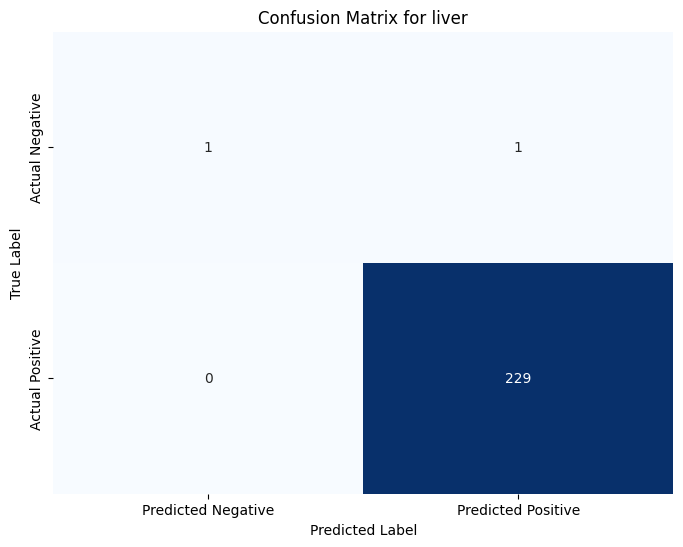

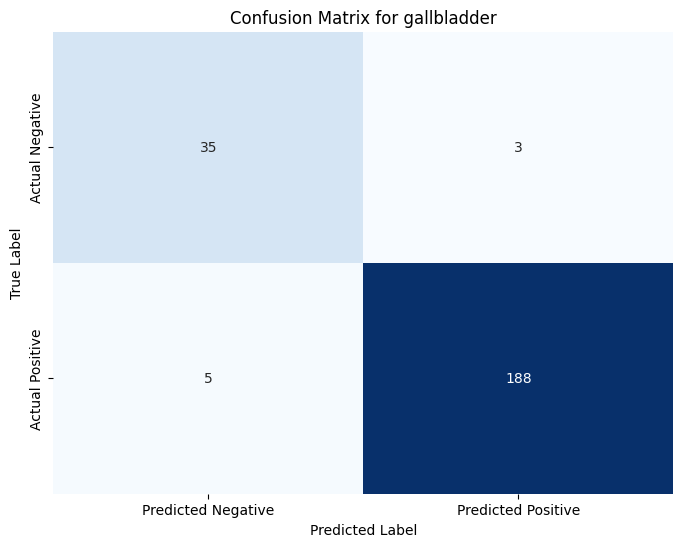

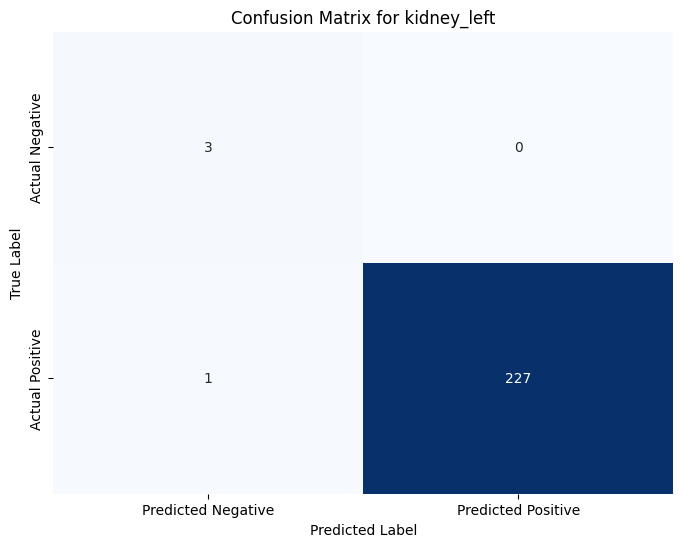

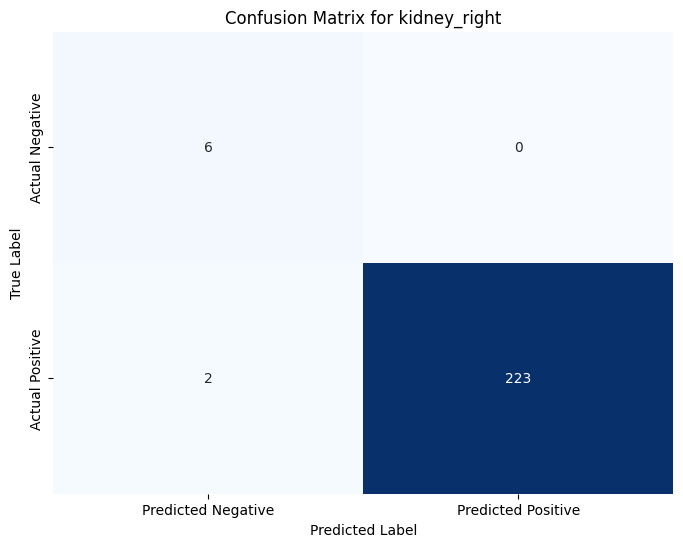

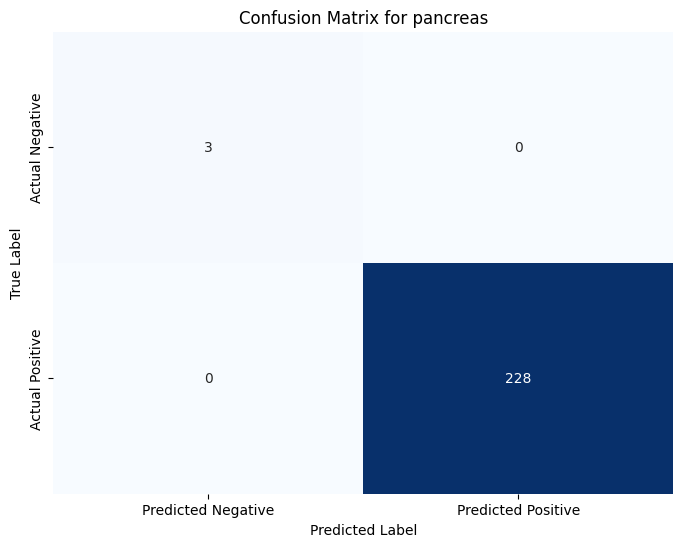

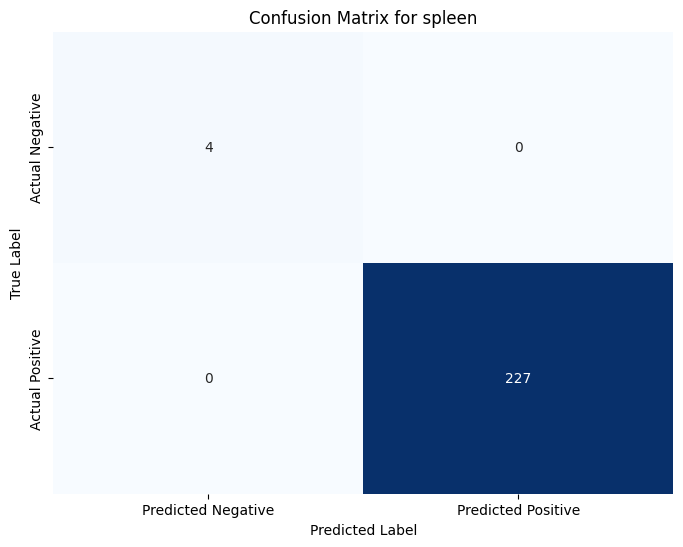

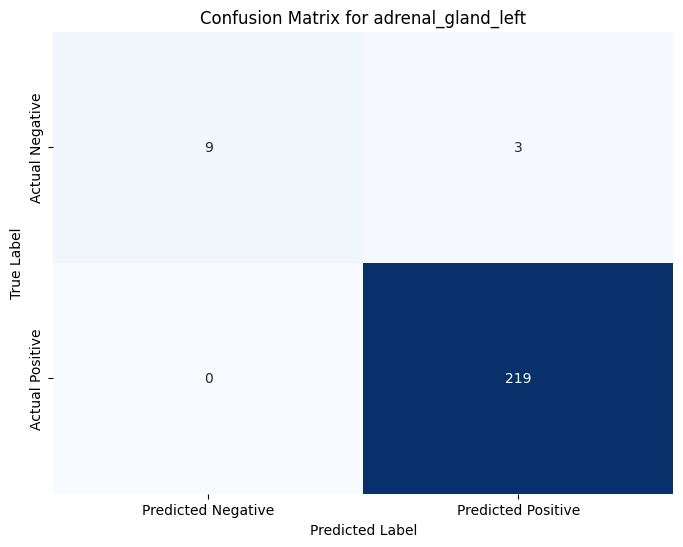

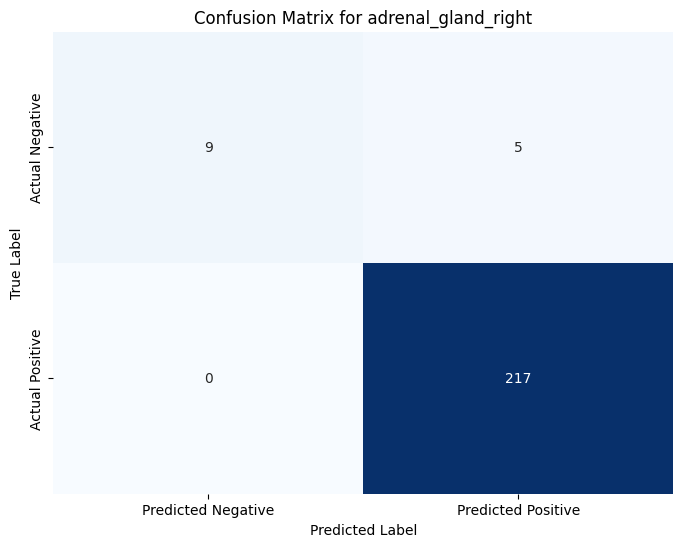

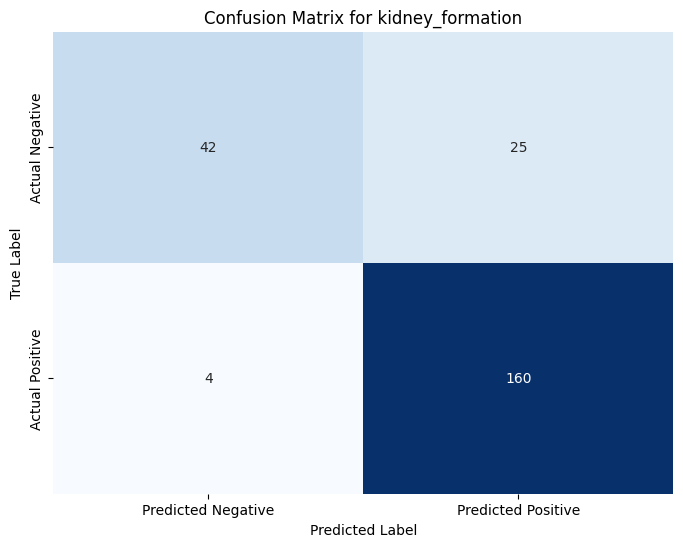

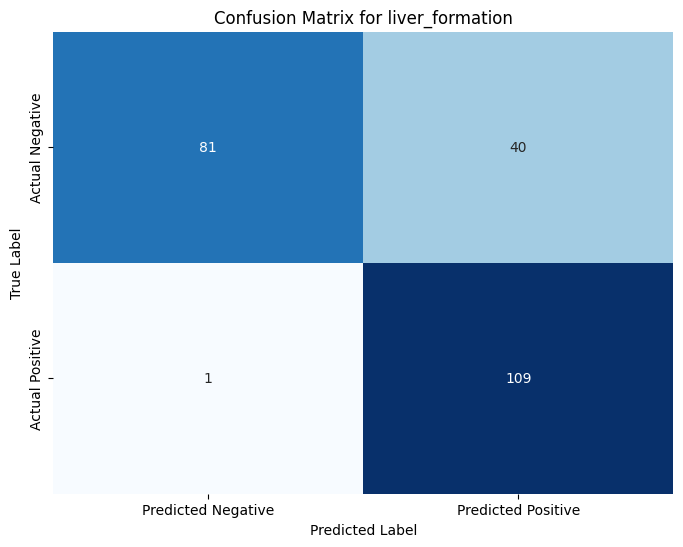

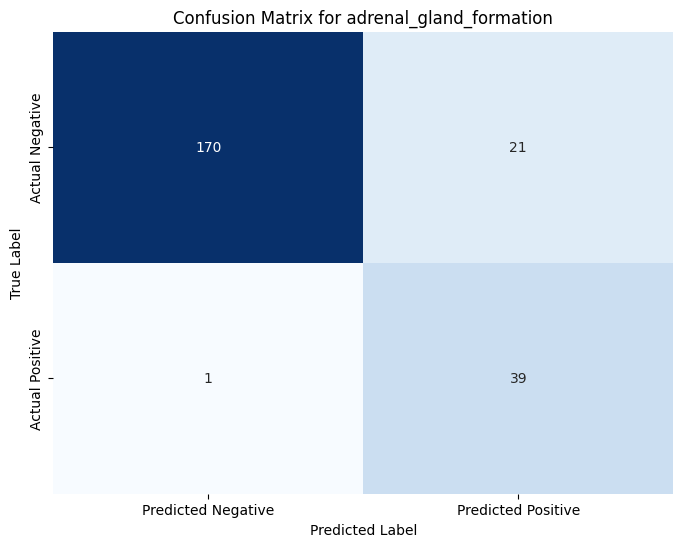

Label: liver
Sensitivity: 1.0000
Specificity: 0.5000

Label: gallbladder
Sensitivity: 0.9741
Specificity: 0.9211

Label: kidney_left
Sensitivity: 0.9956
Specificity: 1.0000

Label: kidney_right
Sensitivity: 0.9911
Specificity: 1.0000

Label: pancreas
Sensitivity: 1.0000
Specificity: 1.0000

Label: spleen
Sensitivity: 1.0000
Specificity: 1.0000

Label: adrenal_gland_left
Sensitivity: 1.0000
Specificity: 0.7500

Label: adrenal_gland_right
Sensitivity: 1.0000
Specificity: 0.6429

Label: kidney_formation
Sensitivity: 0.9756
Specificity: 0.6269

Label: liver_formation
Sensitivity: 0.9909
Specificity: 0.6694

Label: adrenal_gland_formation
Sensitivity: 0.9750
Specificity: 0.8901



In [1]:
import json
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_folder = '/home/eolika/Desktop/BlueMind/nnUNet/trains/nnUNet_results/Dataset901_mosaic_abdominal_pathology/nnUNetTrainer_MOSAIC_500_QuarterLR_NoMirroring__Mosaic_nnUNetPlannerResEncL_stdres_NoRsmp_24G__3d_fullres_stdres_NoRsmp'
folds = ['fold_0']

with open(f"{results_folder}/dataset.json", 'r') as f:
    labels_data = json.load(f)['labels']

# Remove background label
del labels_data['background']

def calculate_binary_sensitivity_and_specificity(label, summary):
    TP = FP = FN = TN = 0

    # Iterate through each case in the summary
    for case in summary['metric_per_case']:
        n_ref = case['metrics'][str(label)]['n_ref']
        n_pred = case['metrics'][str(label)]['n_pred']
        
        if n_ref > 0 and n_pred > 0:
            TP += 1
        elif n_ref > 0 and n_pred == 0:
            FN += 1
        elif n_ref == 0 and n_pred > 0:
            FP += 1
        elif n_ref == 0 and n_pred == 0:
            TN += 1

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    return TP, FP, FN, TN, sensitivity, specificity

# Initialize a dictionary to store results for each label
results = {label: {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0, 'sensitivity': 0, 'specificity': 0} for label in labels_data.values()}

# Iterate through each fold and calculate metrics
for fold in folds:
    if os.path.exists(f"{results_folder}/{fold}/validation/summary.json"):
        with open(f"{results_folder}/{fold}/validation/summary.json", 'r') as f:
            summary = json.load(f)
        
        for label_name, label in labels_data.items():
            TP, FP, FN, TN, sensitivity, specificity = calculate_binary_sensitivity_and_specificity(label, summary)
            results[label]['TP'] += TP
            results[label]['FP'] += FP
            results[label]['FN'] += FN
            results[label]['TN'] += TN

# Calculate average sensitivity and specificity for each label
for label in results.keys():
    TP = results[label]['TP']
    FP = results[label]['FP']
    FN = results[label]['FN']
    TN = results[label]['TN']
    
    results[label]['sensitivity'] = TP / (TP + FN) if (TP + FN) > 0 else 0
    results[label]['specificity'] = TN / (TN + FP) if (TN + FP) > 0 else 0

# Create confusion matrices for each label
confusion_matrices = {}

for label in results.keys():
    confusion_matrix = np.array([
        [results[label]['TN'], results[label]['FP']],
        [results[label]['FN'], results[label]['TP']]
    ])
    confusion_matrices[label] = confusion_matrix

if not os.path.exists(f"{results_folder}/confusion_matrix"):
    os.mkdir(f"{results_folder}/confusion_matrix")

# Plot the confusion matrix for each label
for label_name, label in labels_data.items():
    df_cm = pd.DataFrame(confusion_matrices[label], index=["Actual Negative", "Actual Positive"],
                         columns=["Predicted Negative", "Predicted Positive"])

    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {label_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f"{results_folder}/confusion_matrix/{label_name}.png")
    plt.show()

# Print average sensitivity and specificity for each label
for label_name, label in labels_data.items():
    print(f"Label: {label_name}")
    print(f"Sensitivity: {results[label]['sensitivity']:.4f}")
    print(f"Specificity: {results[label]['specificity']:.4f}")
    print()